In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# feature engineering, selection + preprocessing tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from feature_engine.encoding import OrdinalEncoder

# models
import xgboost as xgb
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score

In [40]:
# !pip install xgboost==2.0.0

In [41]:
# print out xgboost version
import xgboost
print(xgboost.__version__)

2.1.1


In [42]:
# function to check missing & duplicated values
def check_data(df):
    print('-' *50)
    
    missing_data = df.isnull().sum().sum()
    
    print(f'There are {missing_data} missing values in the dataset.')
    print(f'There are {df.duplicated().sum().sum()} duplicated values in the dataset.')
    print('-' *50)
    
    if missing_data > 0:
        print('Missing values:')
        print(df.isnull().sum().sort_values(ascending=False))
        print('-' *50)

In [43]:
df_heart = pd.read_csv('dataset/heart_failure.csv')
df_heart.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [44]:
check_data(df_heart)

--------------------------------------------------
There are 0 missing values in the dataset.
There are 0 duplicated values in the dataset.
--------------------------------------------------


In [45]:
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [46]:
# replacing label for visualization purposes
df_heart['FastingBS'].replace({0: 'Otherwise', 1: '120 mg/dl'}, inplace=True)

Categorical columns proportions

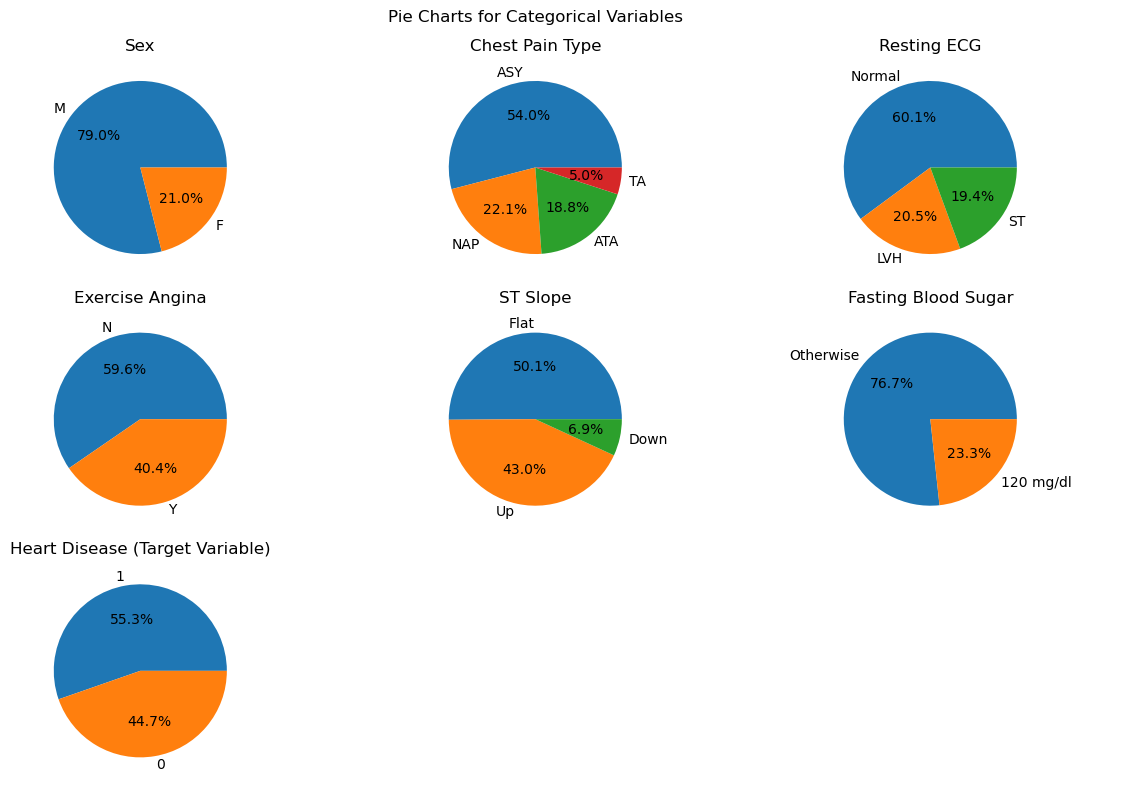

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))  # Create a grid of subplots
plt.style.use('default')

axes[0, 0].pie(df_heart['Sex'].value_counts(), labels=df_heart['Sex'].value_counts().index, autopct='%1.1f%%')
axes[0, 0].set_title('Sex')

axes[0, 1].pie(df_heart['ChestPainType'].value_counts(), labels=df_heart['ChestPainType'].value_counts().index, autopct='%1.1f%%')
axes[0, 1].set_title('Chest Pain Type')

axes[0, 2].pie(df_heart['RestingECG'].value_counts(), labels=df_heart['RestingECG'].value_counts().index, autopct='%1.1f%%')
axes[0, 2].set_title('Resting ECG')

axes[1, 0].pie(df_heart['ExerciseAngina'].value_counts(), labels=df_heart['ExerciseAngina'].value_counts().index, autopct='%1.1f%%')
axes[1, 0].set_title('Exercise Angina')

axes[1, 1].pie(df_heart['ST_Slope'].value_counts(), labels=df_heart['ST_Slope'].value_counts().index, autopct='%1.1f%%')
axes[1, 1].set_title('ST Slope')

axes[1, 2].pie(df_heart['FastingBS'].value_counts(), labels=df_heart['FastingBS'].value_counts().index, autopct='%1.1f%%')
axes[1, 2].set_title('Fasting Blood Sugar')

axes[2, 0].pie(df_heart['HeartDisease'].value_counts(), labels=df_heart['HeartDisease'].value_counts().index, autopct='%1.1f%%')
axes[2, 0].set_title('Heart Disease (Target Variable)')

# Hide the unused subplot
axes[2, 1].axis('off') 
axes[2, 2].axis('off')

fig.suptitle('Pie Charts for Categorical Variables')
plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [48]:
X = df_heart.drop('HeartDisease', axis=1)
y = df_heart['HeartDisease']

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((734, 11), (184, 11), (734,), (184,))

In [50]:
num_cols = [var for var in X_train.columns if X_train[var].dtype != 'object']
cat_cols = [var for var in X_train.columns if X_train[var].dtype == 'object']

print(f'Numerical columns: {num_cols}')
print(f'Categorical columns: {cat_cols}')

Numerical columns: ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
Categorical columns: ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']


Visualizing the distribution of numerical columns

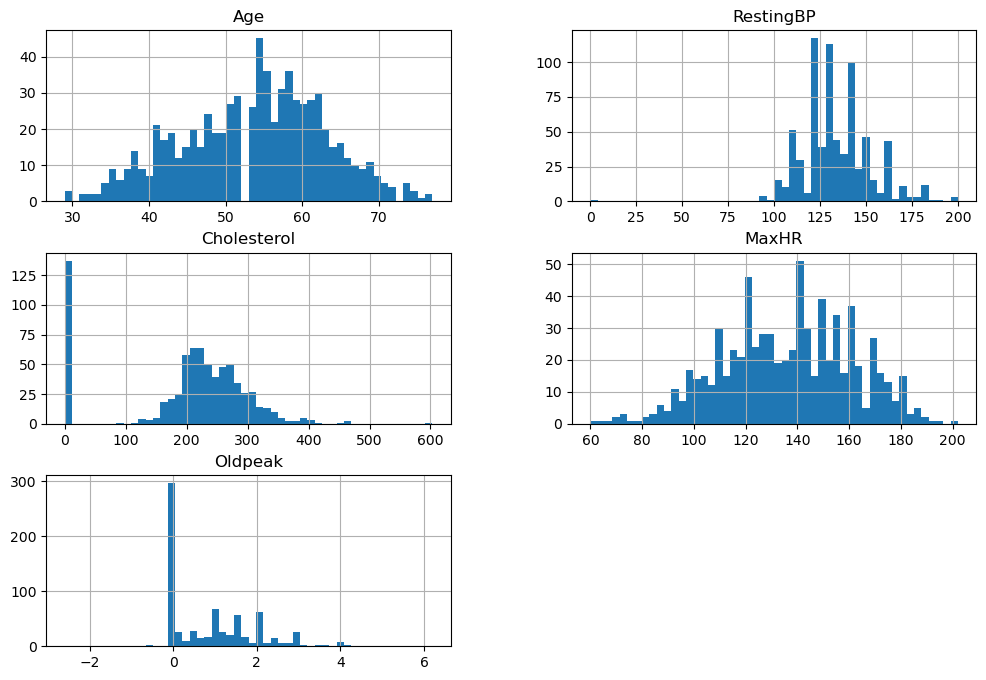

In [51]:
X_train[num_cols].hist(bins=50, figsize=(12, 8))
plt.show()

Skewed distribution:
- Resting BP
- Oldpeak
- Cholesterol

Normal distribution:
- MaxHR
- Age

Feature Scaling

In [52]:
min_max_sc = MinMaxScaler()
std_sc = StandardScaler()


min_max = ['MaxHR', 'Age']
std = ['Cholesterol', 'Oldpeak', 'RestingBP']

X_train[min_max] = min_max_sc.fit_transform(X_train[min_max])
X_test[min_max] = min_max_sc.transform(X_test[min_max])

X_train[std] = std_sc.fit_transform(X_train[std])
X_test[std] = std_sc.transform(X_test[std])

In [53]:
X_train.sample(2, random_state=0)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
411,0.520833,M,ASY,2.547216,-1.846478,120 mg/dl,Normal,0.633803,N,0.549761,Flat
248,0.333333,M,ASY,-0.166285,0.178616,Otherwise,ST,0.492958,Y,0.087745,Flat


Variable Encoding:

In [54]:
arbitrary_enc = OrdinalEncoder(
    encoding_method ='arbitrary',
    variables = cat_cols
)

X_train = arbitrary_enc.fit_transform(X_train)
X_test = arbitrary_enc.transform(X_test)

In [55]:
X_train.sample(2, random_state=0)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
411,0.520833,0,1,2.547216,-1.846478,0,0,0.633803,0,0.549761,2
248,0.333333,0,1,-0.166285,0.178616,1,2,0.492958,1,0.087745,2


Feature Correlation

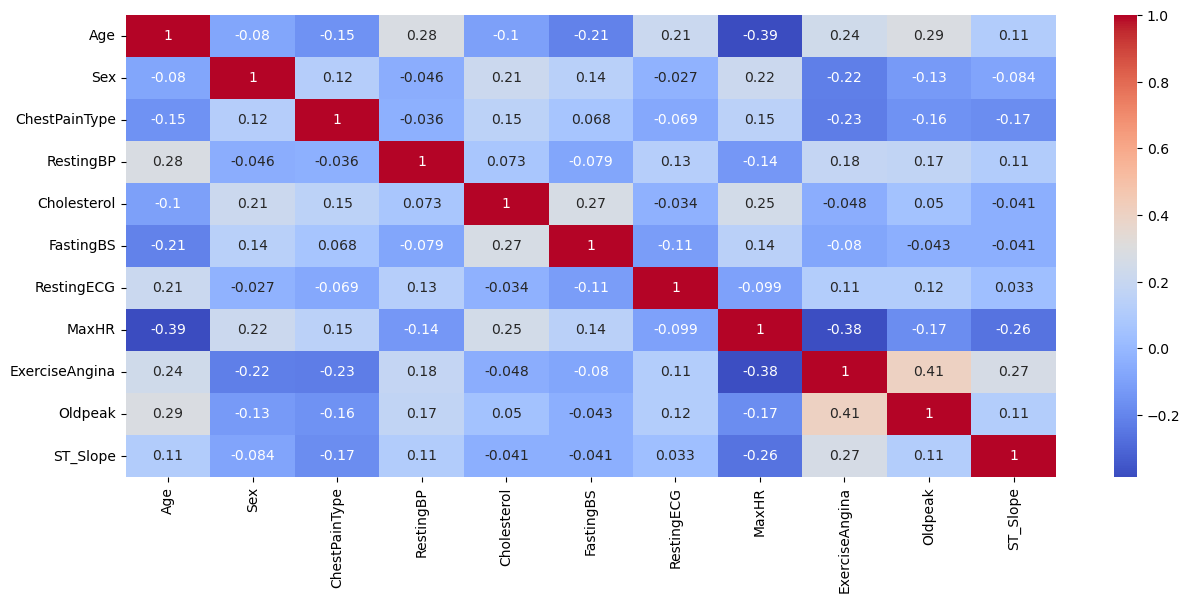

In [56]:
plt.figure(figsize=(15, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.show()

In [57]:
# copying original df
df_heart_copy = df_heart.copy()

arbitrary_enc = OrdinalEncoder(
    encoding_method='arbitrary',
)
df_heart_copy = arbitrary_enc.fit_transform(df_heart_copy)

min_max_sc = MinMaxScaler()
std_sc = StandardScaler()


min_max = ['MaxHR', 'Age']
std = ['Cholesterol', 'Oldpeak', 'RestingBP']

for col in min_max:
    df_heart_copy_col = df_heart_copy[[col]]  # Reshape to 2D array
    df_heart_copy[[col]] = min_max_sc.fit_transform(df_heart_copy_col)

for col in std:
    df_heart_copy_col = df_heart_copy[[col]]  # Reshape to 2D array    
    df_heart_copy[[col]] = std_sc.fit_transform(df_heart_copy_col)

df_heart_copy.sample(2, random_state=0)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
306,0.55102,0,2,-0.940145,-1.818435,1,0,0.669014,0,-0.738623,1,1
711,0.77551,0,2,-0.669935,0.943982,0,2,0.640845,0,-0.457194,1,0


In [58]:
print(f'Length of categorical features: {len(cat_cols)}')
print(f'Length of numerical features: {len(num_cols)}')

Length of categorical features: 6
Length of numerical features: 5


Feature Selection method used: `Mutual Infomation`

In [59]:
X = df_heart_copy.drop(['HeartDisease'], axis=1)
y = df_heart_copy['HeartDisease']

mi_selector = SelectKBest(mutual_info_classif, k='all')
X_new = mi_selector.fit_transform(X, y)

# extract Mutual Information scores
features_scores = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_selector.scores_
})

features_scores = features_scores.sort_values(by='Mutual Information', ascending=False)
features_scores

,Feature,Mutual Information
10,ST_Slope,0.210764
2,ChestPainType,0.126802
8,ExerciseAngina,0.110614
9,Oldpeak,0.100270
7,MaxHR,0.086412
4,Cholesterol,0.069544
3,RestingBP,0.046783
0,Age,0.040941
1,Sex,0.028311
5,FastingBS,0.015774


We'll exclude `RestingECG` & `FastingBS` from our dataset

In [60]:
# dropping excluded columns
X_train.drop(['RestingECG', 'FastingBS'], axis=1, inplace=True)
X_test.drop(['RestingECG', 'FastingBS'], axis=1, inplace=True)

In [61]:
X_train.columns, X_test.columns

(Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'MaxHR',
        'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
       dtype='object'),
 Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'MaxHR',
        'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
       dtype='object'))

Training our models

In [62]:
def model_train(model):
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Predict on both training and test data
    y_preds_train = model.predict(X_train)
    y_preds_test = model.predict(X_test)

    print('-'*50)
    print('Training set performance')
    print()
    print(f"Accuracy: {accuracy_score(y_train, y_preds_train)}")
    print(f"Precision: {precision_score(y_train, y_preds_train)}")
    print(f"Recall: {recall_score(y_train, y_preds_train)}")
    print(f"F1 Score: {f1_score(y_train, y_preds_train)}")
    print(f'ROC-AUC Score: {roc_auc_score(y_train, y_preds_train)}')
    print('-'*50)
    
    print('Test set performance')
    print()
    print(f"Accuracy: {accuracy_score(y_test, y_preds_test)}")
    print(f"Precision: {precision_score(y_test, y_preds_test)}")
    print(f"Recall: {recall_score(y_test, y_preds_test)}")
    print(f"F1 Score: {f1_score(y_test, y_preds_test)}")
    print(f'ROC-AUC Score: {roc_auc_score(y_test, y_preds_test)}')
    print('-'*50)

    # Plot the confusion matrix for test set only
    cm = confusion_matrix(y_test, y_preds_test)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Confusion Matrix (Test Set): {model}')
    plt.show()


--------------------------------------------------
Training set performance

Accuracy: 0.8528610354223434
Precision: 0.8581907090464548
Recall: 0.8753117206982544
F1 Score: 0.8666666666666667
ROC-AUC Score: 0.8505687732620402
--------------------------------------------------
Test set performance

Accuracy: 0.7771739130434783
Precision: 0.8586956521739131
Recall: 0.7383177570093458
F1 Score: 0.7939698492462312
ROC-AUC Score: 0.7847432940890885
--------------------------------------------------


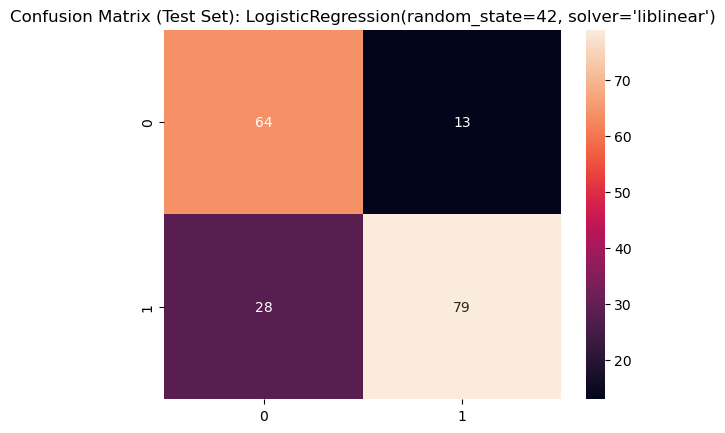

In [63]:
# logistic regression
model_lr = LogisticRegression(solver='liblinear',
                              random_state=42)

model_train(model_lr)

--------------------------------------------------
Training set performance

Accuracy: 0.8392370572207084
Precision: 0.8476658476658476
Recall: 0.8603491271820449
F1 Score: 0.8539603960396039
ROC-AUC Score: 0.8370814704979294
--------------------------------------------------
Test set performance

Accuracy: 0.7771739130434783
Precision: 0.851063829787234
Recall: 0.7476635514018691
F1 Score: 0.7960199004975125
ROC-AUC Score: 0.7829226847918437
--------------------------------------------------


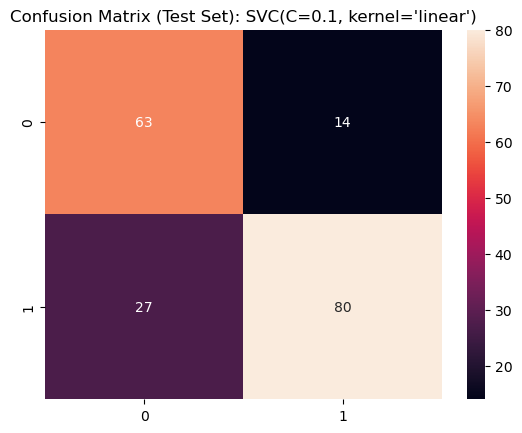

In [64]:
# support vector machine
model_svc = SVC(kernel='linear', C=0.1)
model_train(model_svc)

--------------------------------------------------
Training set performance

Accuracy: 0.885558583106267
Precision: 0.8747044917257684
Recall: 0.9226932668329177
F1 Score: 0.8980582524271845
ROC-AUC Score: 0.8817670538368794
--------------------------------------------------
Test set performance

Accuracy: 0.842391304347826
Precision: 0.875
Recall: 0.8504672897196262
F1 Score: 0.8625592417061612
ROC-AUC Score: 0.8408180604442287
--------------------------------------------------


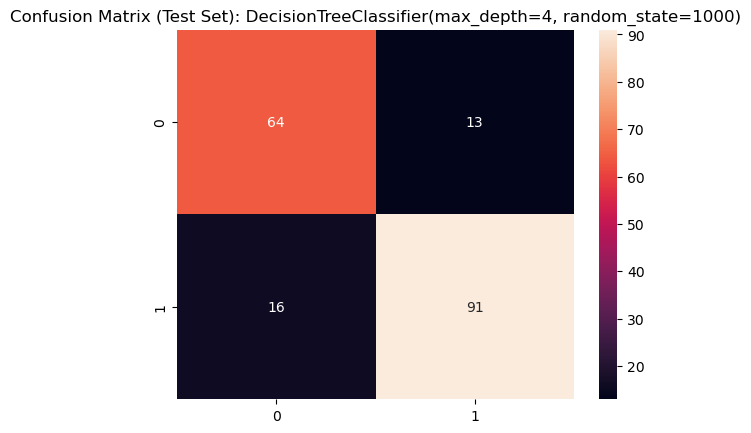

In [65]:
# decision tree
model_dt = DecisionTreeClassifier(random_state = 1000,max_depth = 4,min_samples_leaf = 1)
model_train(model_dt)

--------------------------------------------------
Training set performance

Accuracy: 0.9032697547683923
Precision: 0.8891509433962265
Recall: 0.940149625935162
F1 Score: 0.9139393939393939
ROC-AUC Score: 0.8995042423970104
--------------------------------------------------
Test set performance

Accuracy: 0.8586956521739131
Precision: 0.8857142857142857
Recall: 0.8691588785046729
F1 Score: 0.8773584905660378
ROC-AUC Score: 0.8566573613302585
--------------------------------------------------


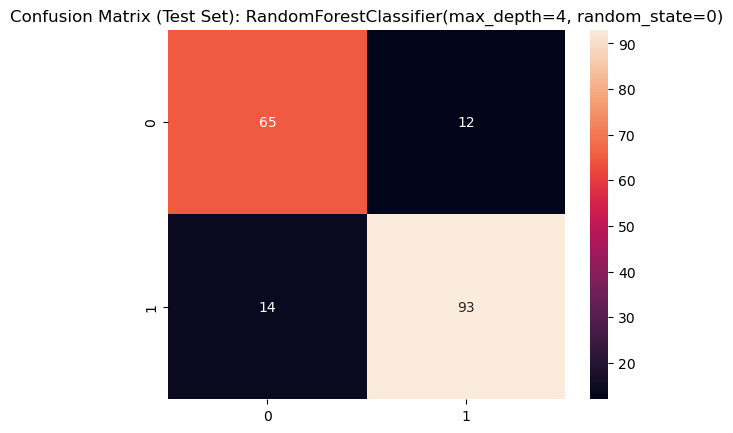

In [66]:
# random forest
model_rf = RandomForestClassifier(max_depth = 4,random_state = 0)
model_train(model_rf)

--------------------------------------------------
Training set performance

Accuracy: 0.9386920980926431
Precision: 0.9299516908212561
Recall: 0.9600997506234414
F1 Score: 0.9447852760736196
ROC-AUC Score: 0.9365063317681771
--------------------------------------------------
Test set performance

Accuracy: 0.8586956521739131
Precision: 0.9090909090909091
Recall: 0.8411214953271028
F1 Score: 0.8737864077669902
ROC-AUC Score: 0.8621191892219929
--------------------------------------------------


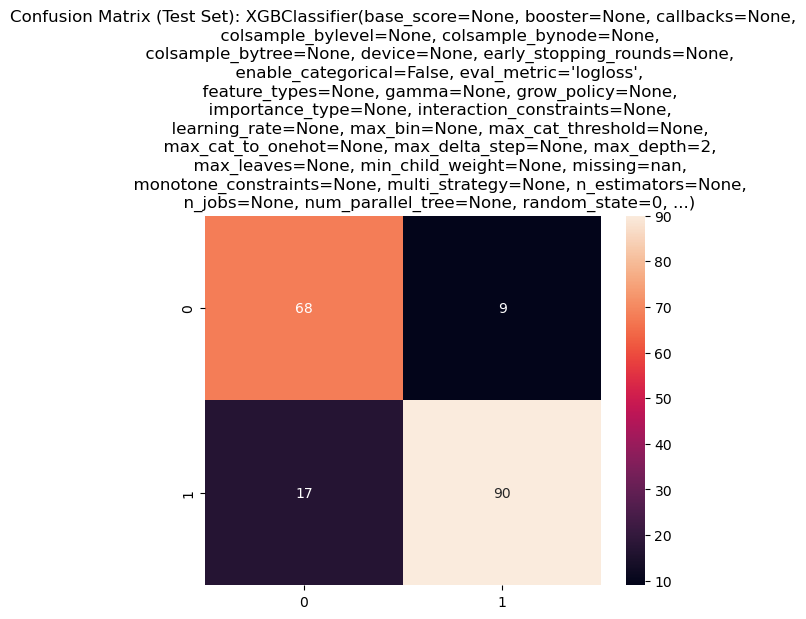

In [67]:
# XGBoost
model_xgb = xgb.XGBClassifier(max_depth= 2,random_state=0, eval_metric='logloss')
model_train(model_xgb)

ROC Curve Comparison

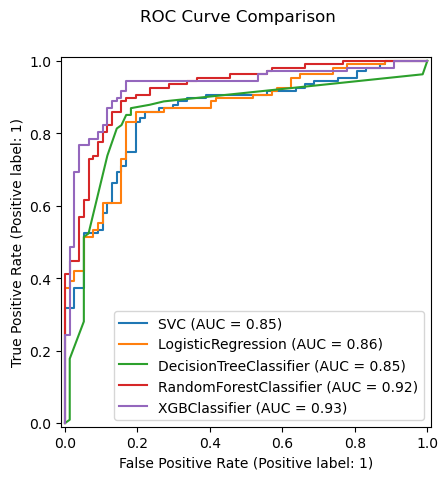

In [68]:
svc_disp = metrics.RocCurveDisplay.from_estimator(model_svc, X_test, y_test)
lr_disp = metrics.RocCurveDisplay.from_estimator(model_lr, X_test, y_test, ax=svc_disp.ax_)
tree_disp = metrics.RocCurveDisplay.from_estimator(model_dt, X_test, y_test, ax=svc_disp.ax_)
rf_disp = metrics.RocCurveDisplay.from_estimator(model_rf, X_test, y_test, ax=svc_disp.ax_)
xgb_disp = metrics.RocCurveDisplay.from_estimator(model_xgb, X_test, y_test, ax=svc_disp.ax_)

lr_disp.figure_.suptitle("ROC Curve Comparison")
plt.show()

In [69]:
# add model performance metric into new dataframe
model_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

# Define the metrics for each model
logistic_regression_metrics = pd.DataFrame([{
    'Model': 'Logistic Regression',
    'Accuracy': 0.8206521739130435,
    'Precision': 0.8775510204081632,
    'Recall': 0.8037383177570093,
    'F1-Score': 0.8390243902439024,
    'ROC-AUC': 0.8239470809564267
}])

svc_metrics = pd.DataFrame([{
    'Model': 'SVC',
    'Accuracy': 0.8043478260869565,
    'Precision': 0.865979381443299,
    'Recall': 0.7850467289719626,
    'F1-Score': 0.8235294117647058,
    'ROC-AUC': 0.808107780070397
}])

dec_tree_metrics = pd.DataFrame([{
    'Model': 'Decision Tree',
    'Accuracy': 0.8532608695652174,
    'Precision': 0.8921568627450981,
    'Recall': 0.8504672897196262,
    'F1-Score': 0.8708133971291866,
    'ROC-AUC': 0.8538050734312417
}])

rf_metrics = pd.DataFrame([{
    'Model': 'Random Forest',
    'Accuracy': 0.875,
    'Precision': 0.8818181818181818,
    'Recall': 0.9065420560747663,
    'F1-Score': 0.8940092165898618,
    'ROC-AUC': 0.8688554436217989
}])

xgb_metrics = pd.DataFrame([{
    'Model': 'XGBoost',
    'Accuracy': 0.875,
    'Precision': 0.9117647058823529,
    'Recall': 0.8691588785046729,
    'F1-Score': 0.8899521531100478,
    'ROC-AUC': 0.876137880810778
}])

model_performance = pd.concat([
    logistic_regression_metrics,
    svc_metrics,
    dec_tree_metrics,
    rf_metrics,
    xgb_metrics
], ignore_index=True)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow; color: black' if v else '' for v in is_max]

model_performance_metric = model_performance.style.apply(highlight_max, subset=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'])

# Display the styled DataFrame
model_performance_metric

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.820652,0.877551,0.803738,0.839024,0.823947
1,SVC,0.804348,0.865979,0.785047,0.823529,0.808108
2,Decision Tree,0.853261,0.892157,0.850467,0.870813,0.853805
3,Random Forest,0.875000,0.881818,0.906542,0.894009,0.868855
4,XGBoost,0.875000,0.911765,0.869159,0.889952,0.876138


XGBoost is the best model for this dataset, but because there's issue with XGBoost 2.1.1 for deployment, we're gonna use RandomForestClassifier to deploy our model with.

In [70]:
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=0, ...)

Save our model for deployment

In [71]:
import pickle as pkl

with open('.pkl/classifier.pkl', 'wb') as f:
    pkl.dump(model_xgb, f)

with open('.pkl/std_scaler.pkl', 'wb') as f:
    pkl.dump(std_sc, f)

with open('.pkl/mms_scaler.pkl', 'wb') as f:
    pkl.dump(min_max_sc, f)

In [72]:
arbitrary_enc.encoder_dict_

{'Sex': {'M': 0, 'F': 1},
 'ChestPainType': {'ATA': 0, 'NAP': 1, 'ASY': 2, 'TA': 3},
 'FastingBS': {'Otherwise': 0, '120 mg/dl': 1},
 'RestingECG': {'Normal': 0, 'ST': 1, 'LVH': 2},
 'ExerciseAngina': {'N': 0, 'Y': 1},
 'ST_Slope': {'Up': 0, 'Flat': 1, 'Down': 2}}

In [73]:
df_heart

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,Otherwise,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,Otherwise,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,Otherwise,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,Otherwise,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,Otherwise,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,Otherwise,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,120 mg/dl,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,Otherwise,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,Otherwise,LVH,174,N,0.0,Flat,1


In [74]:
X_train

,Age,Sex,ChestPainType,RestingBP,Cholesterol,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
795,0.270833,0,0,-0.708985,0.372803,0.943662,0,-0.097061,0
25,0.145833,0,0,-0.166285,0.086146,0.830986,0,-0.836286,1
84,0.562500,0,1,0.919115,0.123134,0.457746,1,0.087745,2
10,0.166667,1,0,-0.166285,0.104640,0.577465,0,-0.836286,1
344,0.458333,0,1,-0.708985,-1.846478,0.309859,0,-0.836286,2
...,...,...,...,...,...,...,...,...,...
106,0.395833,1,1,-0.708985,0.502261,0.352113,0,-0.836286,1
270,0.333333,0,1,-0.708985,0.234098,0.563380,0,-0.836286,1
860,0.645833,0,1,-0.166285,0.493014,0.591549,1,0.457358,1
435,0.645833,0,1,1.027656,-1.846478,0.408451,1,-0.836286,1


In [75]:
X_train.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'MaxHR',
       'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')

In [76]:
y_train

795    0
25     0
84     1
10     0
344    1
      ..
106    0
270    0
860    1
435    0
102    1
Name: HeartDisease, Length: 734, dtype: int64